<a href="https://colab.research.google.com/github/rim-yu/SGU_ANT6320_Assignment/blob/master/Exercise07_rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rossmann Store Sales - 유럽에는 3,000개 약국이 있고 앞으로 몇 주 동안 얼마나 많은 제품을 판매할 것인지 예측하려고 한다. RMSPE(근 평균 제곱 백분율 오류). 제곱근의 제곱 평균을 취한다는 것은 퍼센트 오차임. 제공된 데이터는 적은 수의 파일을 제공했음. 피클 파일을 만드려면 해당 전자 필기장을 실행해야한다. 

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

상점을 대표하는 사람들, 메타 데이터를 보유하고 비슷한 기간 또는 다른 기간에 측정된 일련의 다른 항목이 있을 것임. 시계열 정보, 고객 정보, 메타 데이터 및 기타 정보. 요일을 추가하여 날짜를 지정하고 요일을 추가한 후 일련의 메타 데이터를 추가한다. 연도, 월, 주 ... add_datepart를 실행하고 날짜를 전달하면 이 모든 열을 데이터 세트에 추가한다. 사전 처리된 시계열 정보를 제공할 수 있으면 훨씬 좋다. add_datepart를 수행하면 많은 종류의 시계열 문제를 일반 표 문제로 처리할 수 있다. 

중요한 건 특정 날짜, 특정 매장 ID의 경우 판매 수를 예측하려고 한다는 것임. 데이터의 핵심 사항을 이해하려면 특정 날짜, 매장 판매, sales는 종속 변수임.

(1) 질문 : rossman_data_clean을 통해 rossman 데이터를 시계열 데이터로 만드는 것 같은데 맞나요?

*네 맞습니다*

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = Config().data_path()/'rossmann'
path.mkdir(parents=True, exist_ok=True) # 내가 임의로 추가한 것. 

In [5]:
path

PosixPath('/root/.fastai/data/rossmann')

In [ ]:
! cp /content/drive/"My Drive"/"required files for ML"/rossmann/train_clean /root/.fastai/data/rossmann
# rossman_data_clean을 통해 생성된 train_clean 파일을 path에 옮겨두었음. 

In [ ]:
train_df = pd.read_pickle(path/'train_clean')

In [8]:
train_df.head().T 

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [9]:
n = len(train_df); n # train_df의 갯수. 

844338

### Experimenting with a sample

PreProcessors : transform은 dataset에서 무언가를 가져올 때마다 실행되는 코드 비트이며, 모델이 데이터를 읽을 때마다 데이터를 처리한다. 데이터 보강에 매우 적합하다. 샘플링할 때마다 다른 임의의 값을 얻는다. 데이터 향상은 데이터가 추출될 때마다 임의의 값임. preprocessor는 transform과 매우 유사하다.train set에서 한 번만 작동한다. 그런 다음 생성된 모든 메타 데이터는 validation set 및 test set와 공유되어야 한다. 

PromoInterval에서 문자열이 때로는 NaN을 가짐. PromoInterval은 프로모션이 새로 시작된 달의 이름을 지정하여 Promo2(일부 상점에 대한 지속적인 판촉)가 시작하는 연속 간격을 설명함. 

첫 번째 PreProcessor는 categorify임. PromoInterval에서 가능한 고유한 값을 찾을 것임. 문자열을 숫자로 변환함. 외부적으로 문자열을 보여주고 있지만 내부적으로 숫자를 저장함. 

small_train_df.ProInterval.cat.categories로 내부를 볼 수 있음. 그들 모두의 목록을 보여줌. 우리가 fastai에서 class라고 부르는 것은 모든 카테고리를 포함함. cat.codes로 실제로 저장된 숫자를 보여줌. -1은 NaN을 나타낸다. pandas에서 -1은 누락을 의미함.

두 번째 PreProcessor는 FillMissing임. 누락된 모든 것을 만들 수 있음. CompetitionDistance_na이란 열을 만든다. 새 열에서 누락된 것에 대해 True로 할당한다. 우리가 하는 일은 누락된 것에 대해 CompetitionDistance의 평균을 할당하는 것이다. CompetitionDistance가 연속 변수가 되어야함. procs = procs를 통해 만들 수 있음. procs = [FillMissing, Categorify, Normalize]를 통해 누락된 것을 채우고 싶다, 카테고리화하고 싶다, 정규화하고 싶다고 알릴 수 있는 것임. 

In [ ]:
idx = np.random.permutation(range(n))[:2000] # 순서를 무작위로 바꿔준다. 
idx.sort() # 오름차순. 

small_train_df = train_df.iloc[idx[:1000]] 
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity'] # Mean_Humidity : 평균 습도. 
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [11]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
361,363,5,NaN,250.0,61,9564
454,456,5,NaN,140.0,61,7183
1008,1011,5,"Feb,May,Aug,Nov",490.0,61,10134
1039,1042,5,"Feb,May,Aug,Nov",3440.0,61,6957
1158,46,4,"Jan,Apr,Jul,Oct",1200.0,59,7057


In [12]:
small_test_df.head()
# (2) 질문 : train, test dataframe 갯수(인덱스 기준) 다해서 2000 정도일 것 같은데, 왜 test dataframe의 경우 인덱스가 400,000을 웃도는지 모르겠습니다. 

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
410035,411,6,NaN,8460.0,61,9262
410202,578,6,NaN,12700.0,68,8369
410383,759,6,"Feb,May,Aug,Nov",110.0,68,4781
411046,307,5,NaN,18660.0,84,2205
412040,186,4,"Jan,Apr,Jul,Oct",290.0,80,2961


In [ ]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [14]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
410035,411,6,NaN,8460.0,61,9262
410202,578,6,NaN,12700.0,68,8369
410383,759,6,"Feb,May,Aug,Nov",110.0,68,4781
411046,307,5,NaN,18660.0,84,2205
412040,186,4,"Jan,Apr,Jul,Oct",290.0,80,2961


In [15]:
small_train_df.PromoInterval.cat.categories # small_train_df에 존재하는 PromoInterval들을 보여줌. 

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [16]:
small_train_df['PromoInterval'].cat.codes[:5] # -1은 PromoInterval가 누락된 경우를 보여준다. 
# (3) 질문 : 그럼 0과 1은 무얼 의미하나요? 

361    -1
454    -1
1008    0
1039    0
1158    1
dtype: int8

*위에 categories 보시면 string 3개 있음 -1는 NaN이면 0, 1, 2 뭐엇인가 ?*

In [ ]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [18]:
small_train_df.head() # dataframe 보기 위해 임의로 추가한 코드. 

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
361,363,5,NaN,250.0,61,9564,False
454,456,5,NaN,140.0,61,7183,False
1008,1011,5,"Feb,May,Aug,Nov",490.0,61,10134,False
1039,1042,5,"Feb,May,Aug,Nov",3440.0,61,6957,False
1158,46,4,"Jan,Apr,Jul,Oct",1200.0,59,7057,False


In [23]:
small_train_df["CompetitionDistance"].mean() # CompetitionDistance의 평균값을 보기 위해 임의로 추가한 코드. 

5557.36

In [24]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]
# (4) 질문 : CompetitionDistance이 비었을 경우 CompetitionDistance의 평균값을 할당한다고 강의에서 설명하는데 왜 2350.0인지 모르겠습니다. (위에서 구한 값은 5557.36인데 말이죵..) 

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
127398,291,6,NaN,2350.0,94,4753,True
367593,622,6,NaN,2350.0,64,2884,True


*Competition Distance_na ==True -> 칼럼 보면 답이 있음*

### Preparing full data set

In [ ]:
! cp /content/drive/"My Drive"/"required files for ML"/rossmann/test_clean /root/.fastai/data/rossmann
# rossman_data_clean을 통해 생성된 test_clean 파일을 path에 옮겨두었음. 

In [ ]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [28]:
len(train_df),len(test_df)

(844338, 41088)

In [ ]:
procs=[FillMissing, Categorify, Normalize] # 전처리를 위함. 누락된 거 채우고, 카테고리화 하고, 정규화하고 싶다고 알리는 것. 

In [ ]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']
# 범주형 변수 : 부드러운 곡선 아님. 달마다 다른 행동, 다른 행동 특성을 가질 수 있음.  
# 임베딩 매트릭스를 생성하는 데 도움이 될 것임.
# 카테고리에 라벨이 너무 많지 않은 경우 이를 카디널리티라고 함. 세트의 요소 수. 
# 카디널리티가 높지 않음 데이터를 범주형 변수로 변환하는 것이 좋음. 

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']
# 연속형 변수 

# 독립 변수(위 변수들)를 연구자가 마음대로 조정할 수 있는 변수이고, 독립 변수가 어떻게 변화하는지에 따라 종속 변수가 어떻게 변화하는지 보고 싶은 것임.  
# 보통 독립 변수의 연속형 자료(cont_vars)라면 공변량(covarience)라 부르고, 범주형 자료(cat_vars)라면 요인(factor)라 함. 

In [ ]:
dep_var = 'Sales' # 종속 변수. 
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()
# (5) 질문 : date는 시계열 정보를 추가해주는 것을 의미하는 것인가요?

*https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html*

In [32]:
test_df['Date'].min(), test_df['Date'].max()
# (6) 질문 : 이걸 보고 시계열 정보가 2015년 8월 1일부터 2015년 9월 17일까지 기록되었다고 보면 될까요?

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

*네*

In [33]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut
# valid를 위해서 test_df의 길이만큼 train_df["date"][1000]

41395

In [37]:
train_df.head() # train_df를 보기 위해 임의로 추가한 코드. 
# train_df.head().index.max() 값은 4임.

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,...,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950,25,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579,25,0,0,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9,2009,0,1,1900,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin,2009-09-15,2145,24,1900-01-01,0,0,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4,2015,0,1,1900,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015-04-15,107,3,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [ ]:
valid_idx = range(cut)

In [42]:
valid_idx # valid_idx 직접 확인하기 위해 임의로 추가한 코드. 

range(0, 41395)

In [43]:
df[dep_var].head() # 종속 변수(sales-판매량)를 보여줌. 

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [ ]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

label_cls : dep_var가 종속 변수임. 종속 변수는 판매임. 64비트 정수. dtype이 float인 경우 fastai는 자동으로 회귀(regression)를 수행할 것임을 추측한다. float이 아닌 정수. 따라서 fastai는 분류(classification)를 수행할 것임을 가정한다. 따라서 label_from_df로 label을 지정할 때 원하는 label의 class가 float list임을 알려줘야함. 카테고리 목록이 아님. 그렇지 않으면 MultiCategoryList가 기본값이 됨. fastai의 default. 이 설정은 문제를 자동으로 regression 문제로 바꿈. log가 true면 내 종속 변수의 로그를 가져온다. 이걸 왜하냐면 평가 매트릭이 '근 평균 제곱 백분율 오류'임. y와 y_hat를 가져오면 비율이 아닌 차이가 된다. y의 로그를 취하면 제곱 평균 오차가 되는 것임. 따라서 log=True로 근 평균 제곱 오차를 사용하려 하는 것임. 

In [45]:
doc(FloatList)

## Model

In [ ]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2) # 숫자(1.2)를 곱해서 값을 조금 확대함. 
y_range = torch.tensor([0, max_log_y], device=defaults.device)
# y의 범위는 0에서 최대값보다 조금 더 큼. 
# y_range에 대해 배웠음. 시그모이드를 사용해서 올바른 범위를 얻는 데 도움을 줌.

In [ ]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)
# 1000개의 활성화 입력에서 가져옴. 500개의 활성화 입력값으로 변환. 
# 즉 가중치 행렬(매개변수 행렬)에 500,000개의 매개변수가 포함됨
# 매개변수를 사용하지 않고 정규화를 사용하는 방법은 weight decay를 사용하는 것. 
# 드롭아웃은 일종의 정규화임.(무작위로 비활성화)
# 일반적으로 활성화(activation)만 삭제한다. 
# 첫 번째 레이어에서 0.001로 드롭아웃, 그다음 0.01로 드롭아웃, 임베딩 레이어에서 0.04로 드롭아웃. 

미니 배치를 할 때마다 무작위로 일부 활성화(activation)를 버리고, 다음 미니 배치는 다시 넣고 다른 것을 버림. 활성화 값이 특정 입력값을 기억할 수 없음을 의미함. 정말 잘 작동함. 임의의 비활성화를 실행할 수 있음. 각 레이어마다 다른 드롭아웃 값을 조정해야함. p값은 각 레이어의 드롭아웃 비율임. 드롭아웃에는 흥미로운 게 있음. training time에는 드롭아웃이 있지만 test time에는 드롭아웃을 제거. test time에는 훈련을 하지 않기 때문에 예측할 때 과적합으로 이어지지 않음. 따라서 모든 매개변수에 p(드롭아웃 확률)를 곱하는 것이 좋음. 임베딩 레이어에서 드롭아웃은 드롭아웃 모듈의 인스턴스일 뿐임. 연속변수는 하나의 열에 있음. 그것을 무작위로 드롭아웃해선 안됨. 모든 입력값을 삭제하기 때문. 임베딩 레이어를 임의로 비활성화하는 것이 당연. 이 레이어에서 활성화 값을 임의로 버림. 그 중 일부 활성화 값은 임베딩 레이어의 활성화 값임.  

In [48]:
learn.model # learn 모델 보여줌. 

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

batchNorm1d에서 16개의 입력을 가지는 이유는 16개의 연속 변수(cont_vars)가 있기 때문임. cont_names의 시퀀스의 길이는 16임. batch normalization을 통해 내부 공변량 이동(internal covariate shift)을 줄임으로써 훈련을 가속화하고 있음. (1) 활성화를 통해 미니 배치 평균을 찾기. (2) 미니 배치의 분산을 계산. (3) 각 활성화 값에서 평균을 뺀 다음 표준 편차로 나눈 값을 정규화함. (4) scale and shift가 있음. 바이어스 용어. 감마 베타 매개변수가 있음. 학습 가능함. 

활성화 값 분포의 크기(g를 곱함)와 평균값(b를 더함)을 조정하는 것은 배치 정규화 작업의 본질임. fastai에서 사용되는 또 다른 정규화 방법으로 weight normalization이 있음. 

모멘텀(momentum) 설정. 지수 가중 이동 평균의 계산이 있음. 미니 배치에 대해 평균 및 표준 편차를 계산할 때 실제로 평균 및 표준 편차를 계산하지 않았음. 만약 그렇게 한다면 배치들의 평균과 표준 편차의 차이가 너무 커서 훈련하기 어려울 것임. 모멘텀의 값이 작으면 미니 배치의 평균 및 표준 편차의 차이가 더 작음. 정규화 효과가 적은 것임. 배치 정규화를 사용하면 더 큰 학습 속도를 사용할 수도 있음. 

In [49]:
len(data.train_ds.cont_names) # cont_names의 시퀀스의 길이를 보여줌. 

16

In [50]:
learn.lr_find() # learning rate. 

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


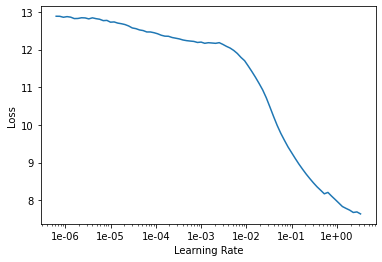

In [51]:
learn.recorder.plot() # learning rate - loss 관계. 

In [52]:
learn.fit_one_cycle(5, 1e-3, wd=0.2) # weight decay로 큰 가중치에 대해 패널티를 부과해 오버피팅을 막자. 

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.027830,0.023841,0.157079,02:40
1,0.021139,0.021513,0.147516,02:40
2,0.017122,0.015750,0.124134,02:40
3,0.012560,0.012555,0.108345,02:41
4,0.009939,0.011768,0.103854,02:40


In [ ]:
learn.save('1')

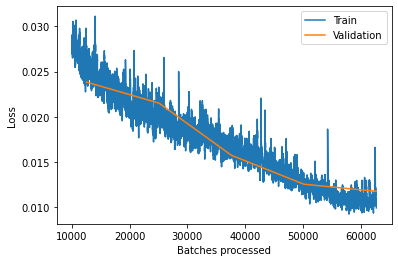

In [54]:
learn.recorder.plot_losses(skip_start=10000)

In [ ]:
learn.load('1');

In [56]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.013379,0.014202,0.111077,02:42
1,0.013186,0.013081,0.112110,02:41
2,0.011105,0.016213,0.118831,02:41
3,0.010400,0.016144,0.124203,02:41
4,0.009020,0.014523,0.118315,02:42


In [ ]:
# learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.011840,0.013236,0.110483
2,0.010765,0.057664,0.129586
3,0.010101,0.042744,0.111584
4,0.008820,0.116893,0.135458
5,0.009144,0.017969,0.126323


(10th place in the competition was 0.108)

In [57]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)